# BrainPy

In this chapter, we will briefly introduce how to realize computational neuroscience model with BrainPy. For more detailed documents and tutorials, please check our github repository [BrainPy](https://github.com/PKU-NIP-Lab/BrainPy) and [BrainModels](https://github.com/PKU-NIP-Lab/BrainModels).

`BrainPy` is a Python platform for computational neuroscience and brain-inspired computation. To model with BrainPy, users should follow 3 steps:

1) Define Python classes for neuron and synapse models. BrainPy provide base classes for different kinds of models, users only need to inherit from those base classes, and define specific methods to tell BrainPy what operations they want the models to take during the simulation. In this process, BrainPy will assist users in numerical integration of differential equations (ODE, SDE, etc.), adaptation of various backend (`Numpy`, `PyTorch`, etc.) and other functions to simplify code logic.

2) Instantiate Python classes as objects of neuron group and synapse connection groups, pass the instantiated objects to BrainPy class `Network`, and call method `run` to simulate the network.

3) Call BrainPy modules like `measure` module and `visualize` module to display the simulation results.

With this overall concept of BrainPy, we will go into more detail about implementations in the following sections. In neural systems, neurons are connected by synapses to build networks, so we will introduce neuron models, synapse models and network models in order.

## 1. Neuron models

Neuron models can be classified into three types from complex to simple: biophysical models, reduced models and firing rate models.

### 1.1 Biophysical models

#### 1.1.1 Hodgkin-Huxley model

Hodgkin and Huxley (1952) recorded the generation of action potential on squid giant axons with voltage clamp technique, and proposed the canonical neuron model called Hudgin-Huxley model (HH model). 

<img src="../images/brainpy_tutorials/1-1.png">	
<center><b> Fig. 1-1 Neuron membrane | NeuroDynamics </b></center>

Fig. 1-1 is a general diagram of neuron membrane with phospholipid bilayer and ion channels. The Na+ ion concentration is higher out of the neuron, and K+ ion concentration is higher in the neuron. Intracellular potential is  lower than extracellular potential.

<img src="../images/brainpy_tutorials/1-2.png">	
<center><b>Fig. 1-2 Equivalent circuit diagram | NeuroDynamics </b></center>

The equivalent circuit diagram of Fig.1-1 is shown in Fig. 1-2, in which the battery $E_L$ refers to the potential difference across membrane, electric current $I$ refers to the external stimulus, capacitance $C$ refers to the hydrophobic phospholipid bilayer with low conductance, resistance $R$ refers to the resistance correspond to leaky current, i.e. the resistance of all non-specific ion channels. 

As Na+ ion channel and K+ ion channel are important in the generation of action potentials, these two ion channels are modeled as the two resistances $R_{Na}$ and $R_K$ in parallel on the right side of the circuit diagram, and the two batteries $E_{Na}$ and $E_K$ refer to the ion potential differences caused by ion concentration differences of Na+ and K+, respectively.

Consider the Kirchhoff’s first law, that is,  for any node in an electrical circuit, the sum of currents flowing into that node is equal to the sum of currents flowing out of that node, Fig. 1-2 can be modeled as differential equations:

$$ C \frac{dV}{dt} = -(\bar{g}_{Na} m^3 h (V - E_{Na}) + \bar{g}_K n^4(V - E_K) + g_{leak}(V - E_{leak})) + I(t) $$

$$\frac{dx}{dt} = \alpha_x(1-x) - \beta_x , x \in \{ Na, K, leak \} $$

That is the HH model. Note that in equation 1, HH model introduces three gating variables m, n and h to control the open/close state of ion channels. To be accurate, variables m and h control the state of Na+ ion channel, and variable n control the state of K+ ion channel. Gating variable dynamics can be expressed in Markov-like form, in which $\alpha_x$ refers to the activation rate of gating variable x, and $\beta_x$ refers to the de-activation rate of x. The expressions of $\alpha_x$ and $\beta_x$ (as shown in equations below) are fitted by experimental data.

$$ \alpha_m(V) = \frac{0.1(V+40)}{1 - exp(\frac{-(V+40)}{10})}$$

$$ \beta_m(V) = 4.0 exp(\frac{-(V+65)}{18})$$

$$ \alpha_h(V) = 0.07 exp(\frac{-(V+65)}{20})$$

$$ \beta_h(V) = \frac{1}{1 + exp(\frac{-(V + 35)}{10})}$$

$$ \alpha_n(V) = \frac{0.01(V+55)}{1 - exp(\frac{-(V+55)}{10})}$$

$$ \beta_n(V) = 0.125 exp(\frac{-(V+65)}{80})$$

How can the users transform these differential equations to code with BrainPy? Take HH model as an example, we may look closely at this process.

**************************

*Note: Readers should pay special attention to discriminate between the terms “model parameters”, “model variables” in dynamic systems and the terms “parameters”, “variables” in programming.*

In BrainPy, users define neuron and synapse models as Python classes. All the classes users may use, as shown in Fig. 1-3, derive from one base class `DynamicSystem`. A neuron model should inherit from the subclass `NeuGroup` of `DynamicSystem` class, and synapse model should inherit from the subclass `TwoEndConn` or `ThreeEndConn`, rely on the number of neurons connected by a single synapse.

<img src="../images/brainpy_tutorials/1-3.png"> 
<center><b> Fig. 1-3 Class inheritance of BrainPy </b></center>

As for HH neuron model, the `HH` class should inherit from `NeuGroup` class. Objects of `HH` class represent groups of HH neuron, and every single neuron in the group will be computed separately. 

    class HH(bp.NeuGroup):
        target_backend = 'general'

Firstly, in HH class definition, users may set variable `target_backend` to specify backend. The value can be set as `general`, which means any backend is supported; it can also be set as a list of backend names:

        target_backend = ['numpy', 'numba', 'pytorch']

The code implementation of model rely on the backend. For example, the acceleration mechanism of `PyTorch` differs from `Numba`, so we may realize the same model differently to maximize the accelerate effect.

Next, we define the differential equation in `derivative` method. Users pass the model variables, time stamp `t` and other model parameters to `derivative` method, BrianPy will classify this three types by the incoming parameter order and integrate the model variables only.

        @staticmethod
        def derivative(V, m, h, n, t, C, gNa, ENa, gK, EK, gL, EL, Iext):
            alpha_m = 0.1 * (V + 40) / (1 - bp.ops.exp(-(V + 40) / 10))
            beta_m = 4.0 * bp.ops.exp(-(V + 65) / 18)
            dmdt = alpha_m * (1 - m) - beta_m * m
            
            dhdt = ...
            
            dndt = ...

            I_Na = (gNa * m ** 3.0 * h) * (V - ENa)
            I_K = (gK * n ** 4.0) * (V - EK)
            I_leak = gL * (V - EL)
            dVdt = (- I_Na - I_K - I_leak + Iext) / C

            return dVdt, dmdt, dhdt, dndt

In the method, we compute the right hand of HH equations (1) – (8), and return $dV/dt$, $dm/dt$, $dn/dt$, $dh/dt$ in order.

However, if you are familiar with numerical integration, you may find that we have not transform the derivatives $dx/dt$ into update processes from $x(t)$ to $x(t+1)$. Don't worry, BrainPy will automatically complete this step of transformation, the details will soon be explained in the constructor.

The contructor of HH class `__init__` needs three types of incoming parameters:

1)	Parameter 	`size`: the number of neurons contained by a class object. Ex. If `size=100`, this object of HH neuron group will include 100 HH neurons.

2)	Parameter list `E_Na` ~ `V_th`: a list of model parameters relies on the model. The number and value of model parameters in this list vary according to the model.

3)	Key word arguments list `**kwargs`: Variable dictionary of key word arguments. `**kwargs` are passed to superclass `NeuGroup` at the end of constructor, and are handled by the super class.

        def __init__(self, size, ENa=50., gNa=120., EK=-77., gK=36.,
                 EL=-54.387, gL=0.03, V_th=20., C=1.0, **kwargs):
            # parameters
            self.ENa = ENa
            ...
            self.V_th = V_th
    
            # variables
            self.V = -65. * bp.ops.ones(size)
            self.m = 0.5 * bp.ops.ones(size)
            self.h = 0.6 * bp.ops.ones(size)
            self.n = 0.32 * bp.ops.ones(size)
            self.spike = bp.ops.zeros(size, dtype=bool)
            self.input = bp.ops.zeros(size)

            # numerical solver
            self.integral = bp.odeint(f=self.derivative)
            super(HH, self).__init__(size=size, **kwargs)

The difference between model parameters (`ENa`, `gNa`, etc.) and model variables (`V`, `m`, `n`, etc.) is, model parameters are only sensitive to the model, but model variables also consider the number of neurons in this neuron group. As shown in Fig. 1-5, if 100 HH neurons are included in one object, then each model parameter is a floating point number, while each model variable is saved in memory as a floating point vector with length 100.

<img src="../images/brainpy_tutorials/1-5.png"> 
<center><b>Fig.1-5 model memory</b></center>

Then we define the numerical method `integral`. Call `odeint` function provided by BrainPy to specify the numerical method are to be used, and `odeint` function will recompile `derivative` method, transform the derivatives to variable update processes. 

BrainPy supports several numerical integration methods including Euler method, Ronge-Kutta method, etc. Users may choose a method with parameter `method`.

        self.integral = bp.odeint(f=self.derivative, method='exponential_euler')
    
At the end of constructor, pass parameter `size` and `**kwargs` to super class `NeuGroup`, finish the initialization of HH class.

    def update(self, _t):
        V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t,
                          self.C, self.gNa, self.ENa, self.gK,
                          self.EK, self.gL, self.EL, self.input)
        self.spike = (self.V < self.V_th) * (V >= self.V_th)
        self.V = V
        self.m = m
        self.h = h
        self.n = n
        self.input[:] = 0

Define `update` method of HH class. Simulation is a series of computing operations on discrete time series, so in `update` method we should define the operations on each time step.

In HH model, we call `integral` method to update variables `V`, `m`, `n`, `h`, judge if there are spikes on each neuron and reset the external input of current moment.

To use HH class, we instantiate a neuron group with 100 HH neurons. The param `monitors` is passed into super class `NeuGroup` as `**kwargs`. All the model variables marked by the monitor list will be recorded by BrainPy during the simulation, and users can access the records after simulation in `neu.mon.*`.

Pass neuron group object `neu` to class `Network`, instantiate a network object `net` including this neuron group. Call method `run` of class `Network`, simulate for 200 ms and give all the neurons  external inputs of amplitude 10 during the simulation.

In [13]:
import brainpy as bp

class HH(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, m, h, n, t, C, gNa, ENa, gK, EK, gL, EL, Iext):
        alpha = 0.1 * (V + 40) / (1 - bp.ops.exp(-(V + 40) / 10))
        beta = 4.0 * bp.ops.exp(-(V + 65) / 18)
        dmdt = alpha * (1 - m) - beta * m

        alpha = 0.07 * bp.ops.exp(-(V + 65) / 20.)
        beta = 1 / (1 + bp.ops.exp(-(V + 35) / 10))
        dhdt = alpha * (1 - h) - beta * h

        alpha = 0.01 * (V + 55) / (1 - bp.ops.exp(-(V + 55) / 10))
        beta = 0.125 * bp.ops.exp(-(V + 65) / 80)
        dndt = alpha * (1 - n) - beta * n

        I_Na = (gNa * m ** 3.0 * h) * (V - ENa)
        I_K = (gK * n ** 4.0) * (V - EK)
        I_leak = gL * (V - EL)
        dVdt = (- I_Na - I_K - I_leak + Iext) / C

        return dVdt, dmdt, dhdt, dndt

    def __init__(self, size, ENa=50., gNa=120., EK=-77., gK=36.,
                 EL=-54.387, gL=0.03, V_th=20., C=1.0, **kwargs):
        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.C = C
        self.V_th = V_th

        # variables
        num = bp.size2len(size)
        self.V = -65. * bp.ops.ones(num)
        self.m = 0.5 * bp.ops.ones(num)
        self.h = 0.6 * bp.ops.ones(num)
        self.n = 0.32 * bp.ops.ones(num)
        self.spike = bp.ops.zeros(num, dtype=bool)
        self.input = bp.ops.zeros(num)

        # numerical solver
        self.integral = bp.odeint(f=self.derivative, method='exponential_euler')
        super(HH, self).__init__(size=size, **kwargs)

    def update(self, _t):
        V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t,
                                   self.C, self.gNa, self.ENa, self.gK,
                                   self.EK, self.gL, self.EL, self.input)
        self.spike = (self.V < self.V_th) * (V >= self.V_th)
        self.V = V
        self.m = m
        self.h = h
        self.n = n
        self.input[:] = 0

After simulation, call `visualize` module of BrainPy, paint the V-t plot of HH model.

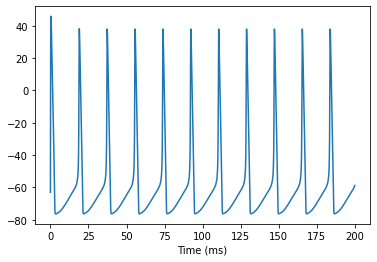

In [14]:
import brainpy as bp

neu = HH(100, monitors=['V'])
net = bp.Network(neu)
net.run(200., inputs=(neu, 'input', 5.))

bp.visualize.line_plot(neu.mon.ts, neu.mon.V, show=True)

The V-t plot of HH model simulated with BrainPy is painted above. During the simulation period, we give the HH neuron a constant external stimulus. Receiving the stimulus, the membrane potential integrates slowly for a while, then spikes to a high value, generates an action potential and resets to resting potential. Two action potentials are unlikely to generate continuously, but there is a certain interval between spikes, called refractory period.

These series of membrane potential change are similar to the typical behavior of neurons found in biophysical experiments, and can be mapped to the equations. For example, the existence of refractory  period is because of the different activation and de-activation rate of gating variables.

### 1.2 Reduced models

In last section we realized the Hodgkin-Huxley model inspired by biophysical experiments. Although HH mode is precise, it will consume ample computing resources and spend running time on details.

To reduce this consumption on time and resources, sometimes researchers can accept the cost of certain accuracy. The reduced models introduced in this section is simple and easy to compute, while they can still represent the main pattern of neuron behavior.

#### 1.2.1 Leaky Integrate-and-Fire model

The most typical reduced model is the Leaky Integrate-and-Fire model (LIF model) presented by Lapicque (1907). 

LIF model can be seen as a combination of integrate process represented by differential equation and spike process represented by conditional judgment:

$$ \tau \frac{dV}{dt} = - (V - V_{rest}) + R I(t)$$

If  $V > V_{th}$, neuron fire, $ V \gets V_{reset}$.

The `derivative` method of LIF model is simpler than of HH model. However the `update` method is more complex because of the conditional judgement.

In [15]:
class LIF(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, t, Iext, V_rest, R, tau):
        dvdt = (-V + V_rest + R * Iext) / tau
        return dvdt

    def __init__(self, size, t_refractory=1., V_rest=0.,
                 V_reset=-5., V_th=20., R=1., tau=10., **kwargs):
        # parameters
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.R = R
        self.tau = tau
        self.t_refractory = t_refractory

        # variables
        num = bp.size2len(size)
        self.t_last_spike = bp.ops.ones(num) * -1e7
        self.input = bp.ops.zeros(num)
        self.V = bp.ops.ones(num) * V_rest
        self.refractory = bp.ops.zeros(num, dtype=bool)
        self.spike = bp.ops.zeros(num, dtype=bool)

        self.integral = bp.odeint(self.derivative)
        super(LIF, self).__init__(size=size, **kwargs)

    def update(self, _t):
        refractory = (_t - self.t_last_spike) <= self.t_refractory
        V = self.integral(self.V, _t, self.input, self.V_rest, self.R, self.tau)
        V = bp.ops.where(refractory, self.V, V)
        spike = self.V_th <= V
        self.t_last_spike = bp.ops.where(spike, _t, self.t_last_spike)
        self.V = bp.ops.where(spike, self.V_reset, V)
        self.refractory = refractory | spike
        self.input[:] = 0.
        self.spike = spike

Note that we write `update` method in vector form here. If the backend is `Numba`, then we can also write the same LIF model with `prange` loop, for `Numba` support parallel acceleration on `prange` loop:

    def update(self, _t):
        for i in prange(self.size[0]):
            spike = 0.
            refractory = (_t - self.t_last_spike[i] <= self.t_refractory)
            if not refractory:
                V = self.integral(self.V[i], _t, self.input[i], self.V_rest, self.R, self.tau)
                spike = (V >= self.V_th)
                if spike:
                    V = self.V_reset
                    self.t_last_spike[i] = _t
                self.V[i] = V
            self.spike[i] = spike
            self.refractory[i] = refractory or spike
            self.input[i] = 0.

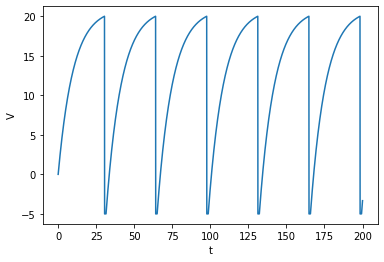

In [17]:
neu = LIF(100, monitors=['V', 'refractory', 'spike'])
net = bp.Network(neu)
net.run(duration=200., inputs=(neu, 'input', 21.))
bp.visualize.line_plot(neu.mon.ts, neu.mon.V,
                       xlabel="t", ylabel="V", show=True)

Compare to the HH model, LIF model does not model the burst of membrane potential when generates a spike.

#### 1.2.2 Quadratic Integrate-and-Fire model

#TODO

#### 1.2.3 Exponential Integrate-and-Fire model
Exponential Integrate-and-Fire model (ExpIF model) (Fourcaud-Trocme et al., 2003) is more expressive than QuaIF model.

$$ \tau \frac{dV}{dt} = - (V - V_{rest}) + \Delta_T e^{\frac{V - V_T}{\Delta_T}} + R I(t)$$

In [19]:
class ExpIF(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, t, I_ext, V_rest, delta_T, V_T, R, tau):
        dvdt = (- V + V_rest \
                + delta_T * bp.ops.exp((V - V_T) / delta_T) + R * I_ext) \
               / tau
        return dvdt

    def __init__(self, size, V_rest=-65., V_reset=-68.,
                 V_th=-30., V_T=-59.9, delta_T=3.48,
                 R=10., C=1., tau=10., t_refractory=1.7,
                 **kwargs):
        # parameters
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.V_T = V_T
        self.delta_T = delta_T
        self.R = R
        self.C = C
        self.tau = tau
        self.t_refractory = t_refractory

        # variables
        self.V = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        self.spike = bp.ops.zeros(size, dtype=bool)
        self.refractory = bp.ops.zeros(size, dtype=bool)
        self.t_last_spike = bp.ops.ones(size) * -1e7

        self.integral = bp.odeint(self.derivative)
        super(ExpIF, self).__init__(size=size, **kwargs)

    def update(self, _t):
        refractory = (_t - self.t_last_spike) <= self.t_refractory
        V = self.integral(self.V, _t, self.input, self.V_rest, self.delta_T, self.V_T, self.R, self.tau)
        V = bp.ops.where(refractory, self.V, V)
        spike = self.V_th <= V
        self.t_last_spike = bp.ops.where(spike, _t, self.t_last_spike)
        self.V = bp.ops.where(spike, self.V_reset, V)
        self.refractory = refractory | spike
        self.input[:] = 0.
        self.spike = spike

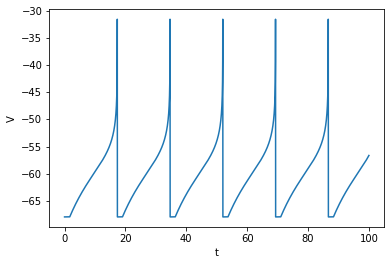

In [20]:
neu = ExpIF(16, monitors=['V', 'spike', 'refractory'])

neu.run(duration=100, inputs=('input', 1.))
bp.visualize.line_plot(neu.mon.ts, neu.mon.V,
                       xlabel="t", ylabel="V",
                       show=True)

We may see in the figure above, with the model parameter V_T, ExpIF model reproduce the rapid growth of membrane potential before a spike, achieve a better simulation result.

#### 1.2.4 Adaptative Exponential Integrate-and-Fire model

To reproduce the adaptation behavior of neurons, researchers add a weight variable w to existing integrate-and-fire models like LIF, QuaIF and ExpIF models. Here we introduce a typical one Adaptative Exponential Integrate-and-Fire model (AdExIF model)(Gerstner et al, 2014).

$$ \tau_m \frac{dV}{dt} = - (V - V_{rest}) + \Delta_T e^{\frac{V - V_T}{\Delta_T}} - R w + R I(t)$$
$$ \tau_w \frac{dw}{dt} = a(V - V_{rest})- w + b \tau_w \sum \delta(t - t^f))$$

The firing rate of AdExIF neuron decreases over time. It simulates the adaptation of neurons, and is controlled by the weight variable w.

In [25]:
class AdExIF(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, w, t, I_ext, V_rest, delta_T, V_T, R, tau, tau_w, a):
        dwdt = (a * (V - V_rest) - w) / tau_w
        dVdt = (- (V - V_rest) + delta_T * bp.ops.exp((V - V_T) / delta_T) - R * w + R * I_ext) / tau
        return dVdt, dwdt

    def __init__(self, size, V_rest=-65., V_reset=-68.,
                 V_th=-30., V_T=-59.9, delta_T=3.48,
                 a=1., b=1., R=10., tau=10., tau_w=30.,
                 t_refractory=0., **kwargs):
        # parameters
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.V_T = V_T
        self.delta_T = delta_T
        self.a = a
        self.b = b
        self.R = R
        self.tau = tau
        self.tau_w = tau_w
        self.t_refractory = t_refractory

        # variables
        num = bp.size2len(size)
        self.V = bp.ops.ones(num) * V_reset
        self.w = bp.ops.zeros(size)
        self.input = bp.ops.zeros(num)
        self.spike = bp.ops.zeros(num, dtype=bool)
        self.refractory = bp.ops.zeros(num, dtype=bool)
        self.t_last_spike = bp.ops.ones(num) * -1e7

        self.integral = bp.odeint(f=self.derivative, method='euler')

        super(AdExIF, self).__init__(size=size, **kwargs)

    def update(self, _t):
        refractory = (_t - self.t_last_spike) <= self.t_refractory
        V, w = self.integral(self.V, self.w, _t, self.input, self.V_rest,
                             self.delta_T, self.V_T, self.R, self.tau,
                             self.tau_w, self.a)
        V = bp.ops.where(refractory, self.V, V)
        spike = self.V_th <= V
        self.t_last_spike = bp.ops.where(spike, _t, self.t_last_spike)
        self.V = bp.ops.where(spike, self.V_reset, V)
        self.w = bp.ops.where(spike, w + self.b, w)
        self.refractory = refractory | spike
        self.input[:] = 0.
        self.spike = spike

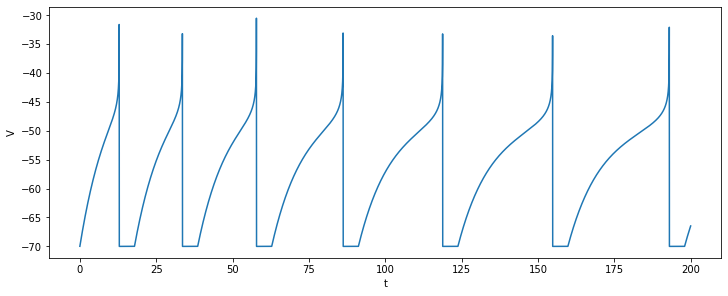

In [30]:
import brainpy as bp

backend = 'numpy'
bp.backend.set(backend=backend, dt=.005)

duration = 200
I_ext = 65
neu = AdExIF(size=1, monitors=['V', 'spike', 'refractory'],
             a=.5, b=7, R=.5, tau=9.9, tau_w=100,
             V_reset=-70, V_rest=-70, V_th=-30,
             V_T=-50, delta_T=2., t_refractory=5.)

neu.run(duration, inputs=('input', I_ext))
fig, gs = bp.visualize.get_figure(1, 1, 4, 10)
bp.visualize.line_plot(neu.mon.ts, neu.mon.V,
                       xlabel="t", ylabel="V")


#### 1.2.5 Resonate-and-Fire model

Other than the integrators we introduced above, there is another neuron type called resonator.

<img src="../images/brainpy_tutorials/1-11.png"> (integrator vs. resonator)

The interactions between ion channels generates the subthreshold oscillation od resonator. To model this oscillation, Resonate-and-Fire model includes two model variables x, y to represent the current-like and voltage-like variables in neurons.

$$\frac{dx}{dt} = bx - wy$$

$$\frac{dy}{dt} = wx + by$$

When spike,

$$ x \gets 0, y \gets 1$$

After a short stimulus is given, paint the trajectory of x and y on complex field, we can see the both variables decaying to zero in a nearly circle trajectory. The voltage-like variable y acting like a resonator here.

In [31]:
class ResonateandFire(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, x, t, b, omega):
        dVdt = omega * x + b * V
        dxdt = b * x - omega * V
        return dVdt, dxdt

    def __init__(self, size, b=-1., omega=10.,
                 V_th=1., V_reset=1., x_reset=0.,
                 **kwargs):
        # parameters
        self.b = b
        self.omega = omega
        self.V_th = V_th
        self.V_reset = V_reset
        self.x_reset = x_reset

        # variables
        self.V = bp.ops.zeros(size)
        self.x = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        self.spike = bp.ops.zeros(size, dtype=bool)

        self.integral = bp.odeint(self.derivative)
        super(ResonateandFire, self).__init__(size=size, **kwargs)

    def update(self, _t):
        x = self.x + self.input
        V, x = self.integral(self.V, x, _t, self.b, self.omega)
        sp = (V > self.V_th)
        V[sp] = self.V_reset
        x[sp] = self.x_reset
        self.V = V
        self.x = x
        self.spike = sp
        self.input[:] = 0

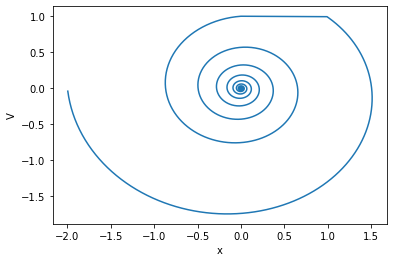

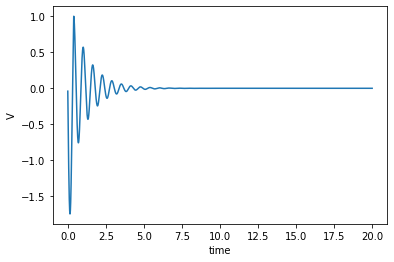

In [58]:
bp.backend.set('numpy', dt=0.002)
group = ResonateandFire(1, monitors=['x', 'V'], show_code=False)
current = bp.inputs.spike_current(points=[0.0], lengths=0.002,
                                  sizes=-2., duration=20.)
group.run(duration=20., inputs=('input', current))
bp.visualize.line_plot(
    group.mon.x, group.mon.V, 
    xlabel = 'x', ylabel = 'V',
    show=True)
bp.visualize.line_plot(
    group.mon.ts, group.mon.V, 
    xlabel = 'time', ylabel = 'V',
    show=True)

#### 1.2.6 Hindmarsh-Rose model

To simulate the bursting spike pattern in neurons (i.e. continuously firing in a short interval), Hindmarsh and Rose (1984) proposed Hindmarsh-Rose neuron model, import a third model variable as slow variable to control the bursting of neuron.

$$\frac{d V}{d t} = y - a V^3 + b V^2 - z + I$$

$$\frac{d y}{d t} = c - d V^2 - y$$

$$\frac{d z}{d t} = r (s (V - V_{rest}) - z)$$

In [33]:
class HindmarshRose(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, y, z, t, a, b, I_ext, c, d, r, s, V_rest):
        dVdt = y - a * V * V * V + b * V * V - z + I_ext
        dydt = c - d * V * V - y
        dzdt = r * (s * (V - V_rest) - z)
        return dVdt, dydt, dzdt

    def __init__(self, size, a=1., b=3.,
                 c=1., d=5., r=0.01, s=4.,
                 V_rest=-1.6, **kwargs):
        # parameters
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.r = r
        self.s = s
        self.V_rest = V_rest

        # variables
        self.z = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        self.V = bp.ops.ones(size) * -1.6
        self.y = bp.ops.ones(size) * -10.

        self.integral = bp.odeint(self.derivative)
        super(HindmarshRose, self).__init__(size=size, **kwargs)

    def update(self, _t):
        self.V, self.y, self.z = self.integral(self.V, self.y, self.z, _t,
                                               self.a, self.b, self.input,
                                               self.c, self.d, self.r, self.s,
                                               self.V_rest)
        self.input[:] = 0.

parameters is set to firing mode <irregular_bursting>


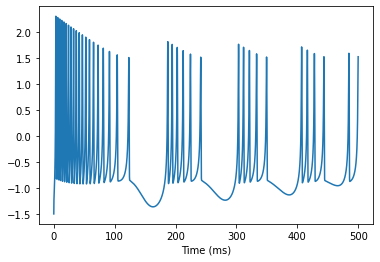

In [46]:
import brainpy as bp

bp.backend.set('numba', dt=0.02)
mode = 'irregular_bursting'
param = {'quiescence': [1.0, 2.0],  # a
         'spiking': [3.5, 5.0],  # c
         'bursting': [2.5, 3.0],  # d
         'irregular_spiking': [2.95, 3.3],  # h
         'irregular_bursting': [2.8, 3.7],  # g
         }
# set params of b and I_ext corresponding to different firing mode
print(f"parameters is set to firing mode <{mode}>")

group = HindmarshRose(size=10, b=param[mode][0],
                                          monitors=['V', 'y', 'z'])

group.run(500., inputs=('input', param[mode][1]))
bp.visualize.line_plot(group.mon.ts, group.mon.V, show=True)

In Fig.1-12, the three model variables x, y, z change on time. Variable z changes much slower than x and y, so z is the slow variable.

We should mention that x and y are changing periodically during the simulation. Can BrainPy help us analysis the reason of this periodicity?

parameters is set to firing mode <spiking>


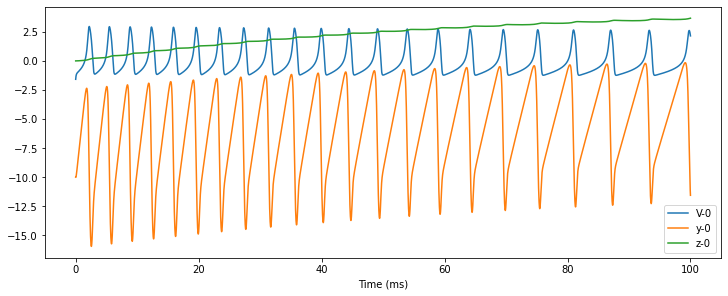

In [61]:
mode = 'spiking'
print(f"parameters is set to firing mode <{mode}>")
group = HindmarshRose(size=10, b=param[mode][0],
                      monitors=['V', 'y', 'z'])
group.run(100., inputs=('input', param[mode][1]))
fig, gs = bp.visualize.get_figure(1, 1, 4, 10)
fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(group.mon.ts, group.mon.V, legend = 'V')
bp.visualize.line_plot(group.mon.ts, group.mon.y, legend = 'y')
bp.visualize.line_plot(group.mon.ts, group.mon.z, legend = 'z', show=True)

<center><b>Fig.1-12 HR model: variable-t plot</b></center>

Yes. With the module `analysis` of BrainPy, users can do simple dynamic analysis, including 1D/2D bifurcation analysis, fast-slow variable bifurcation analysis and 2D/3D phase plane drawing.

Here we take 2D phase plane drawing as an example. Passing the differential eqution, target variables, fix variables and parameters to `PhasePlane` class in `analysis` module, we can instantiate a PhasePlane analyzer object based on differential equation.

In [51]:
# Phase plane analysis
ppanalyzer = bp.analysis.PhasePlane(
    neu.integral,
    target_vars = {'V': [-3., 3.], 'y': [-20., 5.]},
    fixed_vars = {'z': 0.},
    pars_update = {'I_ext':param[mode][1], 'a': 1., 'b': 3., 
                   'c': 1., 'd': 5., 'r': 0.01, 's': 4.,
                   'V_rest': -1.6}
)
ppanalyzer.plot_nullcline()
ppanalyzer.plot_fixed_point()
ppanalyzer.plot_vector_field()
ppanalyzer.plot_trajectory(
    [{'V': 1., 'y': 0., 'z': -0.}],
    duration=100., 
    show=True
)

ModelUseError: "b" is not a valid parameter in "<function ode_brainpy_int_of_derivative at 0x0000026A4E55AD38>" model.

<img src="../images/brainpy_tutorials/1-16.png">

Call the `plot_nullcline`, `plot_vector_field`, `plot_fixed_point`, `plot_trajectory` method of phase plane analyzer, users can paint nullcline, vector filed, fixed points and trajectory of the dynamic system.

In HR model, the trajectory of x and y approaches a limit cycle, that’s why these two variables change periodically.

#### 1.2.7 Generalized Integrate-and-Fire model

In [ ]:
#TODO

### 1.3 Firing Rate models

Firing Rate models are simpler than reduced models. In these models, each compute unit represents a neuron group, the membrane potential variable V in single neuron models is replaced by firing rate variable a (or r or /niu). Here we introduce a canonical firing rate unit.

#### 1.3.1 Firing Rate Units

#TODO

## 3. Network models

We have introduced how to model neurons and synapses with BrainPy, now we will introduce two main types of network models: 1) spiking neural networks model and compute each neuron or synapse separately; 2) firing rate networks simplify neuron groups in the network as firing rate units and compute each neuron group as one unit.

### 3.1 Spiking Neural Network

#### 3.1.1 E/I balanced network

In 1990s, biologists found in experiments that neuron activities in brain cortex show a temporal irregular spiking pattern. This pattern exists widely in **xx, xx** area etc., but researchers knew few about the mechanism and function of it.

Vreeswijk and Sompolinsky (1996) proposed E/I balanced network to explain this irregular spiking pattern. The feature of this network is the strong, random and sparse synapse connections between neurons. Because of this feature and corresponding parameter settings, each neuron in the network will receive great excitatory and inhibitory input from within the network, but these two types of input will cancel each other, and maintain the total internal input at a relatively small order of magnitude, which is only enough to generate action potentials.

The randomness and noise in E/I balanced network give an internal input which varies with time and space at the order of threshold potential to each neuron in the network. Therefore, the firing of neurons also has randomness,  ensures that E/I balanced network can generate temporal irregular firing pattern spontaneously.

Vreeswijk and Sompolinsky also suggested a possible function of this irregular firing pattern: E/I balanced network can respond to the changes of external stimulus quickly.

(3-1)()

As shown in Fig. 3-1, when there is no external input, the distribution of neurons’ membrane potentials in E/I balanced network follows a relatively uniform random distribution between resting potential and threshold potential.

When we give the network a small constant external stimulus, there are always some neurons whose membrane potentials fall near the threshold potential. Turn the stimulus on and these neurons will soon meet the threshold, therefore spike rapidly. On the network scale, the firing rate of neurons in the network can adjust rapidly once the input changes.

Simulation suggests that the delay of network response to input is the same order of magnitude as synapse delay, and is significantly less than the delay of a single neuron that facing the same stimulus at resting potential generates a spike.

As a result, we say E/I balanced network may provide a fast response mechanism for neural networks. 

<img src="../images/brainpy_tutorials/3-2.png">
<center><b>Fig.3-2 Structure of E/I balanced network</b></center>

Fig. 3-2 shows the structure of E/I balanced network:

1)	Neurons: LIF neurons are used in the network. The neurons can be divided into excitatory neurons and inhibitory neurons, the number of two types of neurons are N_E: N_I = 4:1.

    neu_E = LIF(N_E, monitors = ['spike'])
    neu_I = LIF(N_I, monitors = ['spike'])
    neu_E.V = V_rest + np.random.random(N_E) * (V_th - V_rest)
    neu_I.V = V_rest + np.random.random(N_I) * (V_th - V_rest)

2)	Synapses: Exponential synapses are used in the network. 4 groups of synapse connections are generated between the two groups of neurons, that is, excitatory-excitatory connection (E2E conn), excitatory-inhibitory connection (E2I conn), inhibitory-excitatory connection (I2E conn) and inhibitory-inhibitory connection (I2I conn). To express the excitatory or inhibitory of the synapse connections, we define synapse weight with different signal.

    syn_E2E = Syn(pre = neu_E, post = neu_E,
              conn = bp.connect.FixedProb(prob = prob))
    syn_E2I = Syn(pre = neu_E, post = neu_I,
              conn = bp.connect.FixedProb(prob = prob))
    syn_I2E = Syn(pre = neu_I, post = neu_E,
              conn = bp.connect.FixedProb(prob = prob))
    syn_I2I = Syn(pre = neu_I, post = neu_I,
              conn = bp.connect.FixedProb(prob = prob))
    syn_E2E.w = JE
    syn_E2I.w = JE
    syn_I2E.w = -JI
    syn_I2I.w = -JI

3)	Inputs: All neurons in the network receive a constant input current from outside of network.

    net.run(500., inputs = [(neu_E, 'input', 3.), (neu_I, 'input', 3.)], report = True)

See above section 1 and 2 for definition of LIF neuron class and Exponential synapse class. Visualize the simulation result of E/I balanced network, the network firing rate changes from strong synchronization to irregular fluctuation.

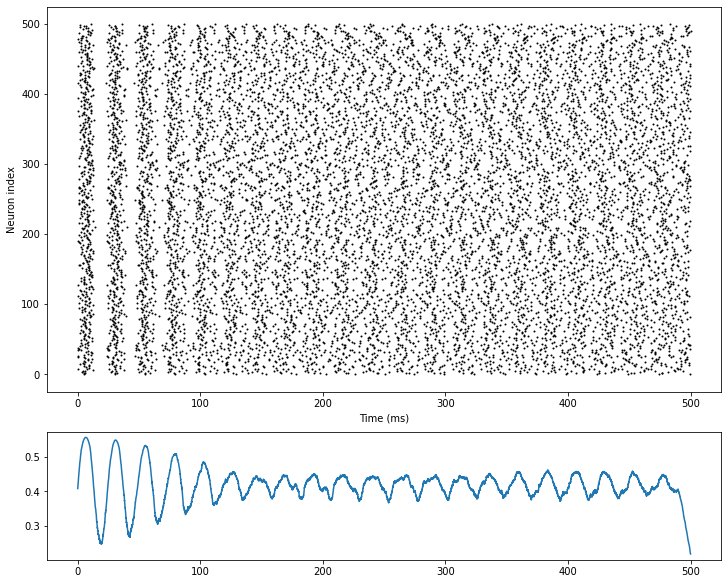

In [54]:
import brainpy as bp
import matplotlib.pyplot as plt
import numpy as np
from numba import prange

bp.backend.set('numba')

N_E = 500
N_I = 500
prob = 0.1

tau = 10.
V_rest = -52.
V_reset = -60.
V_th = -50.

class LIF(bp.NeuGroup):
    target_backend = 'general'

    def __init__(self, size, V_rest = V_rest, V_reset = V_reset,
                 V_th = V_th, tau = tau, **kwargs):
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.tau = tau

        self.V = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        self.spike = bp.ops.zeros(size, dtype = bool)

        super(LIF, self).__init__(size = size, **kwargs)

    @staticmethod
    @bp.odeint
    def integral(V, t, I_ext, V_rest, tau):
        return (-V + V_rest + I_ext) / tau

    def update(self, _t):
        V = self.integral(self.V, _t, self.input, self.V_rest, self.tau)
        sp = V > self.V_th
        V[sp] = self.V_reset
        self.V = V
        self.spike = sp
        self.input[:] = 0.

tau_decay = 2.
JE = 1 / np.sqrt(prob * N_E)
JI = 1 / np.sqrt(prob * N_I)

class Syn(bp.TwoEndConn):
    target_backend = 'general'

    def __init__(self, pre, post, conn,
                 tau_decay = tau_decay, w = 0., 
                 **kwargs):
        self.tau_decay = tau_decay
        self.w = w

        self.conn = conn(pre.size, post.size)
        self.pre_ids, self.post_ids = conn.requires('pre_ids', 'post_ids')
        self.size = len(self.pre_ids)

        self.s = bp.ops.zeros(self.size)
        self.g = bp.ops.zeros(self.size)

        super(Syn, self).__init__(pre = pre, post = post, **kwargs)
    
    @staticmethod
    @bp.odeint(method = 'rk4')
    def integral(s, t, tau):
        return -s / tau

    def update(self, _t):
        for i in prange(self.size):
            self.s[i] = self.integral(self.s[i], _t, self.tau_decay)
            pre_id = self.pre_ids[i]
            self.s[i] += self.pre.spike[pre_id]
            g = self.w * self.s[i]
            post_id = self.post_ids[i]
            self.post.input[post_id] += g

neu_E = LIF(N_E, monitors = ['spike'])
neu_I = LIF(N_I, monitors = ['spike'])
neu_E.V = V_rest + np.random.random(N_E) * (V_th - V_rest)
neu_I.V = V_rest + np.random.random(N_I) * (V_th - V_rest)

syn_E2E = Syn(pre = neu_E, post = neu_E,
              conn = bp.connect.FixedProb(prob = prob))
syn_E2I = Syn(pre = neu_E, post = neu_I,
              conn = bp.connect.FixedProb(prob = prob))
syn_I2E = Syn(pre = neu_I, post = neu_E,
              conn = bp.connect.FixedProb(prob = prob))
syn_I2I = Syn(pre = neu_I, post = neu_I,
              conn = bp.connect.FixedProb(prob = prob))
syn_E2E.w = JE
syn_E2I.w = JE
syn_I2E.w = -JI
syn_I2I.w = -JI

net = bp.Network(neu_E, neu_I, 
                 syn_E2E, syn_E2I, 
                 syn_I2E, syn_I2I)
net.run(500., inputs = [(neu_E, 'input', 3.), (neu_I, 'input', 3.)])


fig, gs = bp.visualize.get_figure(4, 1, 2, 10)
fig.add_subplot(gs[:3, 0])
bp.visualization.raster_plot(net.ts, neu_E.mon.spike)

fig.add_subplot(gs[3, 0])
rate = bp.measure.firing_rate(neu_E.mon.spike, 5.)
plt.plot(net.ts, rate)
plt.show()

<center><b>Fig.3-3 E/I balanced net raster plot</b></center>

#### 3.1.2 Decision Making Network

The modeling of computational neuroscience networks can correspond to specific physiological tasks, like the visual motion discrimination task (Roitman and Shadlen, 2002). In this task, rhesus watch a video in which random dots move towards left or right with definite coherence. Rhesus are required to choose the direction that most dots move to and give their answer by saccade. At the meantime, researchers record the activity of their LIF neurons by implanted electrode.

<img src="../images/brainpy_tutorials/3-4.png"> 
<center><b>Fig.3-4 Experimental Disgram</b></center>

Wang (2002) proposed a decision making network to model the activity of rhesus LIF neurons during decision making period. As shown in Fig. 3-5, this network is based on E/I balanced network, with excitatory neuron and inhibitory neuron number in the proportion 4:1, and maintain the balanced state by adjusting parameters.

Among the excitatory neuron group, two selective subgroup are chosen, both with a size of 0.15 * N_E. These two subgroups are marked as A and B in Fig. 3-5. Other excitatory neuron are non-selective.

<img src="../images/brainpy_tutorials/3-5.png">
<center><b>Fig.3-5 structure of decision makingnetwork</b></center>

    # def E neurons/pyramid neurons
    neu_A = LIF(N_A, monitors=['spike', 'input', 'V'])
    neu_B = LIF(N_B, monitors=['spike', 'input', 'V'])
    neu_non = LIF(N_non, monitors=['spike', 'input', 'V'])
    # def I neurons/interneurons
    neu_I = LIF(N_I, monitors=['input', 'V'])

As it is in E/I balanced network, synapses can be classified into E2E connection, E2I connection, I2E connection and I2I connection. Excitatory connections are realized with AMPA synapse, inhibitory connections are realized with GABAa synapse. In order to force the network to make decisions between group A and group B, E2E connections are structured. As shown in Sheet 3-1, the strength of synapse connections is higher in the same selective subgroup, and lower between two subgroups or between selective and non-selective subgroup.

<center><b>Sheet 3-1 Weight of synapse connections between E-neurons</b></center>
<img src="../images/brainpy_tutorials/3-6.png">

    syn_A2A_AMPA = AMPA(pre=neu_A, post=neu_A,
                  conn=bp.connect.All2All(),
                  delay=delay_syn)
    syn_A2A_AMPA.g_max = g_max_E2E_AMPA * w_pos

    syn_A2B_AMPA = AMPA(pre=neu_A, post=neu_B,
                  conn=bp.connect.All2All(),
                  delay=delay_syn)
    syn_A2B_AMPA.g_max = g_max_E2E_AMPA * w_neg

    syn_A2non_AMPA = AMPA(pre=neu_A, post=neu_non,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
    syn_A2non_AMPA.g_max = g_max_E2E_AMPA * w_neg

    # ...

We give two types of external inputs to the decision making network: 1) Background inputs from other brain areas without specific meaning. Represented as high frequency Poisson input mediated by AMPA synapse; 2) Stimulus inputs from outside the brain, which are given only to the two selective subgroup A and B. Represented as lower frequency Poisson input mediated by AMPA synapse. To simulate the proportion difference of the dots moving to left and right in physiological experiments, the stimulus frequencies given to A and B group have a certain difference.

    neu_poisson_A = PoissonInput(N_A, freqs=poisson_freq, dt=dt)
    neu_poisson_B = PoissonInput(N_B, freqs=poisson_freq, dt=dt)
    neu_poisson_non = PoissonInput(N_non, freqs=poisson_freq, dt=dt)
    neu_poisson_I = PoissonInput(N_I, freqs=poisson_freq, dt=dt)

    syn_back2A_AMPA = AMPA(pre=neu_poisson_A, post=neu_A,
                    conn=bp.connect.One2One())
    syn_back2B_AMPA = AMPA(pre=neu_poisson_B, post=neu_B,
                    conn=bp.connect.One2One())
    syn_back2non_AMPA = AMPA(pre=neu_poisson_non, post=neu_non,
                     conn=bp.connect.One2One())

During the simulation, group A receive a larger stimulus input than group B (i.e. more random dot move to the direction represented by A), later, considerable differentiation are found between the population activities of the two selective subgroups. In this example, the activity of group A is higher than group B, which means, the network choose the right direction receives higher stimulus.

N_E = 320 = 48 + 48 + 224, N_I = 80
R_E * C_E = 20.0 should be equal to tau_E = 20.0
R_I * C_I = 10.0 should be equal to tau_I = 10.0
the structured weight is: w_pos = 1.7, w_neg = 0.8764705882352941
Check contraints: Weight sum 319.9999999999997         should be equal to N_E = 320
coherence = 25.6, mu_A = 50.24, mu_B = 29.759999999999998
Compilation used 0.0157 s.
Start running ...
Run 10.0% used 11.862 s.
Run 20.0% used 22.960 s.
Run 30.0% used 34.160 s.
Run 40.0% used 45.790 s.
Run 50.0% used 57.161 s.
Run 60.0% used 68.416 s.
Run 70.0% used 79.667 s.
Run 80.0% used 91.376 s.
Run 90.0% used 102.714 s.
Run 100.0% used 113.894 s.
Simulation is done in 113.894 s.

computing fr...
get fr


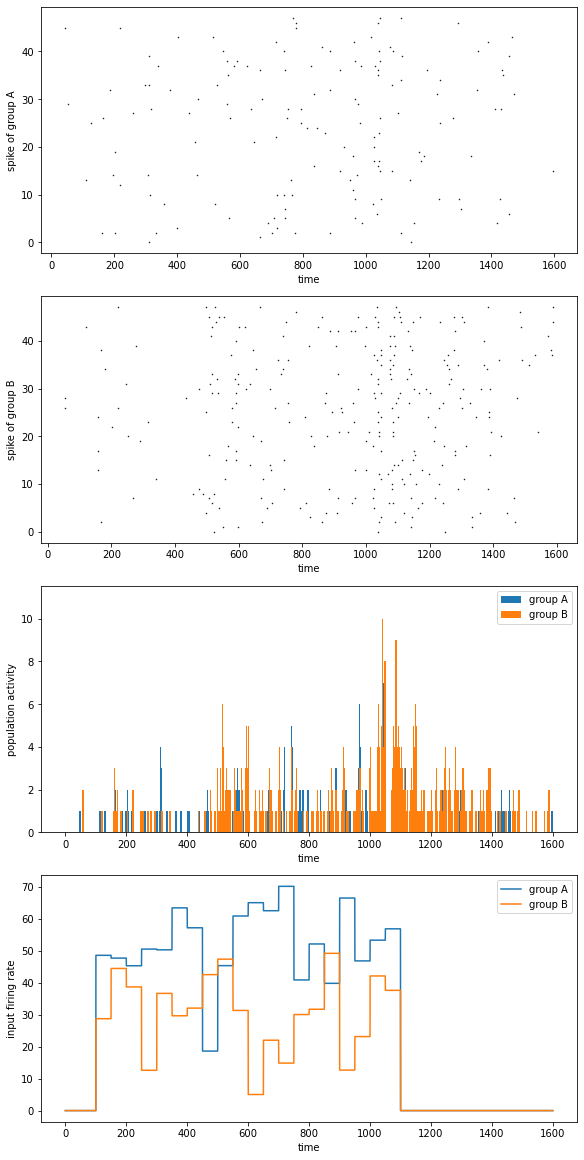

In [1]:
"""
Implementation of the paper:

Wang, Xiao-Jing. "Probabilistic decision making by slow 
reverberation in cortical circuits." Neuron 36.5 (2002): 955-968.
"""
import brainpy as bp
import numpy as np
import matplotlib.pyplot as plt

# set params
# set global params
dt = 0.05  # ms
method = 'exponential'
bp.backend.set('numpy', dt=dt)

# set network params
base_N_E = 1600
base_N_I = 400
net_scale = 5.
N_E = int(base_N_E // net_scale)
N_I = int(base_N_I // net_scale)

f = 0.15  # Note: proportion of neurons activated by one of the two stimulus
N_A = int(f * N_E)
N_B = int(f * N_E)
N_non = N_E - N_A - N_B  # Note: N_E = N_A + N_B + N_non
print(f"N_E = {N_E} = {N_A} + {N_B} + {N_non}, N_I = {N_I}")
# Note: N_E[0:N_A]: A_group
#       N_E[N_A : N_A+N_B]: B_group
#       N_E[N_A + N_B: N_E]: non of A or B

time_scale = 1.
pre_period = 100. / time_scale
stim_period = 1000.
delay_period = 500. / time_scale
total_period = pre_period + stim_period + delay_period

# set LIF neu params
V_rest_E = -70.  # mV
V_reset_E = -55.  # mV
V_th_E = -50.  # mV
g_E = 25. * 1e-3  # uS
R_E = 1 / g_E  # MOhm
C_E = 0.5  # nF
tau_E = 20.  # ms
t_refractory_E = 2.  # ms
print(f"R_E * C_E = {R_E * C_E} should be equal to tau_E = {tau_E}")

V_rest_I = -70.  # mV
V_reset_I = -55.  # mV
V_th_I = -50.  # mV
g_I = 20. * 1e-3  # uS
R_I = 1 / g_I  # Mohm
C_I = 0.2  # nF
tau_I = 10.  # ms
t_refractory_I = 1.  # ms
print(f"R_I * C_I = {R_I * C_I} should be equal to tau_I = {tau_I}")


class LIF(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, t, I_ext, V_rest, R, tau):
        dvdt = (- (V - V_rest) + R * I_ext) / tau
        return dvdt

    def __init__(self, size, V_rest=0., V_reset=0.,
                 V_th=0., R=0., tau=0., t_refractory=0.,
                 **kwargs):
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.R = R
        self.tau = tau
        self.t_refractory = t_refractory

        self.V = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        self.spike = bp.ops.zeros(size, dtype=bool)
        self.refractory = bp.ops.zeros(size, dtype=bool)
        self.t_last_spike = bp.ops.ones(size) * -1e7

        self.integral = bp.odeint(self.derivative)
        super(LIF, self).__init__(size=size, **kwargs)

    def update(self, _t):
        # update variables
        not_ref = (_t - self.t_last_spike > self.t_refractory)
        self.V[not_ref] = self.integral(
            self.V[not_ref], _t, self.input[not_ref],
            self.V_rest, self.R, self.tau)
        sp = (self.V > self.V_th)
        self.V[sp] = self.V_reset
        self.t_last_spike[sp] = _t
        self.spike = sp
        self.refractory = ~not_ref
        self.input[:] = 0.


# set syn params
E_AMPA = 0.  # mV
tau_decay_AMPA = 2  # ms

E_NMDA = 0.  # mV
alpha_NMDA = 0.062  # \
beta_NMDA = 3.57  # \
cc_Mg_NMDA = 1.  # mM
a_NMDA = 0.5  # kHz/ms^-1
tau_rise_NMDA = 2.  # ms
tau_decay_NMDA = 100.  # ms

E_GABAa = -70.  # mV
tau_decay_GABAa = 5.  # ms

delay_syn = 0.5  # ms


class NMDA(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, x, t, tau_rise, tau_decay, a):
        dxdt = -x / tau_rise
        dsdt = -s / tau_decay + a * x * (1 - s)
        return dsdt, dxdt

    def __init__(self, pre, post, conn, delay=0.,
                 g_max=0.15, E=0., cc_Mg=1.2,
                 alpha=0.062, beta=3.57, tau=100,
                 a=0.5, tau_rise=2., **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.alpha = alpha
        self.beta = beta
        self.cc_Mg = cc_Mg
        self.tau = tau
        self.tau_rise = tau_rise
        self.a = a
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # variables
        self.s = bp.ops.zeros(self.size)
        self.x = bp.ops.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size,
                                              delay_time=delay)

        self.integral = bp.odeint(self.derivative)
        super(NMDA, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        self.x += bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat
        self.s, self.x = self.integral(self.s, self.x, _t,
                                       self.tau_rise, self.tau, self.a)

        self.g.push(self.g_max * self.s)
        g_inf = 1 + self.cc_Mg / self.beta * \
                bp.ops.exp(-self.alpha * self.post.V)
        g_inf = 1 / g_inf
        self.post.input -= bp.ops.sum(self.g.pull(), axis=0) * \
                           (self.post.V - self.E) * g_inf


class AMPA(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, t, tau):
        ds = - s / tau
        return ds

    def __init__(self, pre, post, conn, delay=0.,
                 g_max=0.10, E=0., tau=2.0, **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.tau = tau
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # data
        self.s = bp.ops.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size,
                                              delay_time=delay)

        self.int_s = bp.odeint(f=self.derivative, method='euler')
        super(AMPA, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        self.s = self.int_s(self.s, _t, self.tau)
        self.s += bp.ops.unsqueeze(self.pre.spike, 1) * self.conn_mat
        self.g.push(self.g_max * self.s)
        self.post.input -= bp.ops.sum(self.g.pull(), 0) \
                           * (self.post.V - self.E)


class GABAa(bp.TwoEndConn):
    target_backend = 'general'

    @staticmethod
    def derivative(s, t, tau_decay):
        dsdt = - s / tau_decay
        return dsdt

    def __init__(self, pre, post, conn, delay=0.,
                 g_max=0.4, E=-80., tau_decay=6.,
                 **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.tau_decay = tau_decay
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # data
        self.s = bp.ops.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size,
                                              delay_time=delay)

        self.integral = bp.odeint(self.derivative)
        super(GABAa, self).__init__(pre=pre, post=post, **kwargs)

    def update(self, _t):
        self.s = self.integral(self.s, _t, self.tau_decay)
        for i in range(self.pre.size[0]):
            if self.pre.spike[i] > 0:
                self.s[i] += self.conn_mat[i]
        self.g.push(self.g_max * self.s)
        g = self.g.pull()
        self.post.input -= bp.ops.sum(g, axis=0) * (self.post.V - self.E)


# set syn weights (only used in recurrent E connections)
w_pos = 1.7
w_neg = 1. - f * (w_pos - 1.) / (1. - f)
print(f"the structured weight is: w_pos = {w_pos}, w_neg = {w_neg}")
# inside select group: w = w+
# between group / from non-select group to select group: w = w-
# A2A B2B w+, A2B B2A w-, non2A non2B w-
weight = np.ones((N_E, N_E), dtype=np.float)
for i in range(N_A):
    weight[i, 0: N_A] = w_pos
    weight[i, N_A: N_A + N_B] = w_neg
for i in range(N_A, N_A + N_B):
    weight[i, N_A: N_A + N_B] = w_pos
    weight[i, 0: N_A] = w_neg
for i in range(N_A + N_B, N_E):
    weight[i, 0: N_A + N_B] = w_neg
print(f"Check contraints: Weight sum {weight.sum(axis=0)[0]} \
        should be equal to N_E = {N_E}")

# set background params
poisson_freq = 2400.  # Hz
g_max_ext2E_AMPA = 2.1 * 1e-3  # uS
g_max_ext2I_AMPA = 1.62 * 1e-3  # uS

g_max_E2E_AMPA = 0.05 * 1e-3 * net_scale
g_max_E2E_NMDA = 0.165 * 1e-3 * net_scale
g_max_E2I_AMPA = 0.04 * 1e-3 * net_scale
g_max_E2I_NMDA = 0.13 * 1e-3 * net_scale
g_max_I2E_GABAa = 1.3 * 1e-3 * net_scale
g_max_I2I_GABAa = 1.0 * 1e-3 * net_scale

# def neurons
# def E neurons/pyramid neurons
neu_A = LIF(N_A, monitors=['spike', 'input', 'V'])
neu_A.V_rest = V_rest_E
neu_A.V_reset = V_reset_E
neu_A.V_th = V_th_E
neu_A.R = R_E
neu_A.tau = tau_E
neu_A.t_refractory = t_refractory_E
neu_A.V = bp.ops.ones(N_A) * V_rest_E

neu_B = LIF(N_B, monitors=['spike', 'input', 'V'])
neu_B.V_rest = V_rest_E
neu_B.V_reset = V_reset_E
neu_B.V_th = V_th_E
neu_B.R = R_E
neu_B.tau = tau_E
neu_B.t_refractory = t_refractory_E
neu_B.V = bp.ops.ones(N_B) * V_rest_E

neu_non = LIF(N_non, monitors=['spike', 'input', 'V'])
neu_non.V_rest = V_rest_E
neu_non.V_reset = V_reset_E
neu_non.V_th = V_th_E
neu_non.R = R_E
neu_non.tau = tau_E
neu_non.t_refractory = t_refractory_E
neu_non.V = bp.ops.ones(N_non) * V_rest_E

# def I neurons/interneurons
neu_I = LIF(N_I, monitors=['input', 'V'])
neu_I.V_rest = V_rest_I
neu_I.V_reset = V_reset_I
neu_I.V_th = V_th_I
neu_I.R = R_I
neu_I.tau = tau_I
neu_I.t_refractory = t_refractory_I
neu_I.V = bp.ops.ones(N_I) * V_rest_I

# def synapse connections
## define E2E conn
syn_A2A_AMPA = AMPA(pre=neu_A, post=neu_A,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_A2A_NMDA = NMDA(pre=neu_A, post=neu_A,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)

syn_A2B_AMPA = AMPA(pre=neu_A, post=neu_B,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_A2B_NMDA = NMDA(pre=neu_A, post=neu_B,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)

syn_A2non_AMPA = AMPA(pre=neu_A, post=neu_non,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_A2non_NMDA = NMDA(pre=neu_A, post=neu_non,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)

syn_B2A_AMPA = AMPA(pre=neu_B, post=neu_A,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_B2A_NMDA = NMDA(pre=neu_B, post=neu_A,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)

syn_B2B_AMPA = AMPA(pre=neu_B, post=neu_B,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_B2B_NMDA = NMDA(pre=neu_B, post=neu_B,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)

syn_B2non_AMPA = AMPA(pre=neu_B, post=neu_non,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_B2non_NMDA = NMDA(pre=neu_B, post=neu_non,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)

syn_non2A_AMPA = AMPA(pre=neu_non, post=neu_A,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_non2A_NMDA = NMDA(pre=neu_non, post=neu_A,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)

syn_non2B_AMPA = AMPA(pre=neu_non, post=neu_B,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_non2B_NMDA = NMDA(pre=neu_non, post=neu_B,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)

syn_non2non_AMPA = AMPA(pre=neu_non, post=neu_non,
                        conn=bp.connect.All2All(),
                        delay=delay_syn)
syn_non2non_NMDA = NMDA(pre=neu_non, post=neu_non,
                        conn=bp.connect.All2All(),
                        delay=delay_syn)

syn_A2A_AMPA.g_max = g_max_E2E_AMPA * w_pos
syn_A2A_NMDA.g_max = g_max_E2E_NMDA * w_pos

syn_A2B_AMPA.g_max = g_max_E2E_AMPA * w_neg
syn_A2B_NMDA.g_max = g_max_E2E_NMDA * w_neg

syn_A2non_AMPA.g_max = g_max_E2E_AMPA
syn_A2non_NMDA.g_max = g_max_E2E_NMDA

syn_B2A_AMPA.g_max = g_max_E2E_AMPA * w_neg
syn_B2A_NMDA.g_max = g_max_E2E_NMDA * w_neg

syn_B2B_AMPA.g_max = g_max_E2E_AMPA * w_pos
syn_B2B_NMDA.g_max = g_max_E2E_NMDA * w_pos

syn_B2non_AMPA.g_max = g_max_E2E_AMPA
syn_B2non_NMDA.g_max = g_max_E2E_NMDA

syn_non2A_AMPA.g_max = g_max_E2E_AMPA * w_neg
syn_non2A_NMDA.g_max = g_max_E2E_NMDA * w_neg

syn_non2B_AMPA.g_max = g_max_E2E_AMPA * w_neg
syn_non2B_NMDA.g_max = g_max_E2E_NMDA * w_neg

syn_non2non_AMPA.g_max = g_max_E2E_AMPA
syn_non2non_NMDA.g_max = g_max_E2E_NMDA

for i in [syn_A2A_AMPA, syn_A2B_AMPA, syn_A2non_AMPA,
          syn_B2A_AMPA, syn_B2B_AMPA, syn_B2non_AMPA,
          syn_non2A_AMPA, syn_non2B_AMPA, syn_non2non_AMPA]:
    i.E = E_AMPA
    i.tau_decay = tau_decay_AMPA
    i.E = E_NMDA

for i in [syn_A2A_NMDA, syn_A2B_NMDA, syn_A2non_NMDA,
          syn_B2A_NMDA, syn_B2B_NMDA, syn_B2non_NMDA,
          syn_non2A_NMDA, syn_non2B_NMDA, syn_non2non_NMDA]:
    i.alpha = alpha_NMDA
    i.beta = beta_NMDA
    i.cc_Mg = cc_Mg_NMDA
    i.a = a_NMDA
    i.tau_decay = tau_decay_NMDA
    i.tau_rise = tau_rise_NMDA

## define E2I conn
syn_A2I_AMPA = AMPA(pre=neu_A, post=neu_I,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_A2I_NMDA = NMDA(pre=neu_A, post=neu_I,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)

syn_B2I_AMPA = AMPA(pre=neu_B, post=neu_I,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)
syn_B2I_NMDA = NMDA(pre=neu_B, post=neu_I,
                    conn=bp.connect.All2All(),
                    delay=delay_syn)

syn_non2I_AMPA = AMPA(pre=neu_non, post=neu_I,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_non2I_NMDA = NMDA(pre=neu_non, post=neu_I,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)

for i in [syn_A2I_AMPA, syn_B2I_AMPA, syn_non2I_AMPA]:
    i.g_max = g_max_E2I_AMPA
    i.E = E_AMPA
    i.tau_decay = tau_decay_AMPA

for i in [syn_A2I_NMDA, syn_B2I_NMDA, syn_non2I_NMDA]:
    i.g_max = g_max_E2I_NMDA
    i.E = E_NMDA
    i.alpha = alpha_NMDA
    i.beta = beta_NMDA
    i.cc_Mg = cc_Mg_NMDA
    i.a = a_NMDA
    i.tau_decay = tau_decay_NMDA
    i.tau_rise = tau_rise_NMDA

## define I2E conn
syn_I2A_GABAa = GABAa(pre=neu_I, post=neu_A,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_I2B_GABAa = GABAa(pre=neu_I, post=neu_B,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_I2non_GABAa = GABAa(pre=neu_I, post=neu_non,
                        conn=bp.connect.All2All(),
                        delay=delay_syn)
for i in [syn_I2A_GABAa, syn_I2B_GABAa, syn_I2non_GABAa]:
    i.g_max = g_max_I2E_GABAa
    i.E = E_GABAa
    i.tau_decay = tau_decay_GABAa

## define I2I conn
syn_I2I_GABAa = GABAa(pre=neu_I, post=neu_I,
                      conn=bp.connect.All2All(),
                      delay=delay_syn)
syn_I2I_GABAa.g_max = g_max_I2I_GABAa
syn_I2I_GABAa.E = E_GABAa
syn_I2I_GABAa.tau_decay = tau_decay_GABAa


# def background poisson input
class PoissonInput(bp.NeuGroup):
    target_backend = 'general'

    def __init__(self, size, freqs, dt, **kwargs):
        self.freqs = freqs
        self.dt = dt

        self.spike = bp.ops.zeros(size, dtype=bool)

        super(PoissonInput, self).__init__(size=size, **kwargs)

    def update(self, _t):
        self.spike = np.random.random(self.size) \
                     < self.freqs * self.dt / 1000.


neu_poisson_A = PoissonInput(N_A, freqs=poisson_freq, dt=dt)
neu_poisson_B = PoissonInput(N_B, freqs=poisson_freq, dt=dt)
neu_poisson_non = PoissonInput(N_non, freqs=poisson_freq, dt=dt)
neu_poisson_I = PoissonInput(N_I, freqs=poisson_freq, dt=dt)

syn_back2A_AMPA = AMPA(pre=neu_poisson_A, post=neu_A,
                       conn=bp.connect.One2One())
syn_back2B_AMPA = AMPA(pre=neu_poisson_B, post=neu_B,
                       conn=bp.connect.One2One())
syn_back2non_AMPA = AMPA(pre=neu_poisson_non, post=neu_non,
                         conn=bp.connect.One2One())
for i in [syn_back2A_AMPA, syn_back2B_AMPA, syn_back2non_AMPA]:
    i.g_max = g_max_ext2E_AMPA
    i.E = E_AMPA
    i.tau_decay = tau_decay_AMPA

syn_back2I_AMPA = AMPA(pre=neu_poisson_I, post=neu_I,
                       conn=bp.connect.One2One())
syn_back2I_AMPA.g_max = g_max_ext2I_AMPA
syn_back2I_AMPA.E = E_AMPA
syn_back2I_AMPA.tau_decay = tau_decay_AMPA
# Note: all neurons receive 2400Hz background possion inputs

## def stimulus input
# Note: inputs only given to A and B group
mu_0 = 40.
coherence = 25.6
rou_A = mu_0 / 100.
rou_B = mu_0 / 100.
mu_A = mu_0 + rou_A * coherence
mu_B = mu_0 - rou_B * coherence
print(f"coherence = {coherence}, mu_A = {mu_A}, mu_B = {mu_B}")


class PoissonStim(bp.NeuGroup):
    """
    from time <t_start> to <t_end> during the simulation, the neuron 
    generates a possion spike with frequency <self.freq>. however, 
    the value of <self.freq> changes every <t_interval> ms and obey 
    a Gaussian distribution defined by <mean_freq> and <var_freq>.
    """
    target_backend = 'general'

    def __init__(self, size, dt=0., t_start=0., t_end=0., t_interval=0.,
                 mean_freq=0., var_freq=20., **kwargs):
        self.dt = dt
        self.stim_start_t = t_start
        self.stim_end_t = t_end
        self.stim_change_freq_interval = t_interval
        self.mean_freq = mean_freq
        self.var_freq = var_freq

        self.freq = 0.
        self.t_last_change_freq = -1e7
        self.spike = bp.ops.zeros(size, dtype=bool)

        super(PoissonStim, self).__init__(size=size, **kwargs)

    def update(self, _t):
        if _t > self.stim_start_t and _t < self.stim_end_t:
            if _t - self.t_last_change_freq \
                    >= self.stim_change_freq_interval:  # change freq
                self.freq = np.random.normal(self.mean_freq, self.var_freq)
                self.freq = max(self.freq, 0)
                self.t_last_change_freq = _t
            self.spike = np.random.random(self.size) \
                         < (self.freq * self.dt / 1000)
        else:
            self.freq = 0.
            self.spike[:] = False


neu_input2A = PoissonStim(N_A, dt=dt, t_start=pre_period,
                          t_end=pre_period + stim_period,
                          t_interval=50., mean_freq=mu_A, var_freq=10.,
                          monitors=['freq'])
neu_input2B = PoissonStim(N_B, dt=dt, t_start=pre_period,
                          t_end=pre_period + stim_period,
                          t_interval=50., mean_freq=mu_B, var_freq=10.,
                          monitors=['freq'])

syn_input2A_AMPA = AMPA(pre=neu_input2A, post=neu_A,
                        conn=bp.connect.One2One())
syn_input2A_AMPA.g_max = g_max_ext2E_AMPA
syn_input2A_AMPA.E = E_AMPA
syn_input2A_AMPA.tau_decay = tau_decay_AMPA

syn_input2B_AMPA = AMPA(pre=neu_input2B, post=neu_B,
                        conn=bp.connect.One2One())
syn_input2B_AMPA.g_max = g_max_ext2E_AMPA
syn_input2B_AMPA.E = E_AMPA
syn_input2B_AMPA.tau_decay = tau_decay_AMPA

# build & simulate network
net = bp.Network(
    neu_poisson_A, neu_poisson_B,
    neu_poisson_non, neu_poisson_I,
    # bg input
    syn_back2A_AMPA, syn_back2B_AMPA,
    syn_back2non_AMPA, syn_back2I_AMPA,
    # bg conn
    neu_input2A, neu_input2B,
    # stim input
    syn_input2A_AMPA, syn_input2B_AMPA,
    # stim conn
    neu_A, neu_B, neu_non, neu_I,
    # E(A B non), I neu
    syn_A2A_AMPA, syn_A2A_NMDA,
    syn_A2B_AMPA, syn_A2B_NMDA,
    syn_A2non_AMPA, syn_A2non_NMDA,
    syn_B2A_AMPA, syn_B2A_NMDA,
    syn_B2B_AMPA, syn_B2B_NMDA,
    syn_B2non_AMPA, syn_B2non_NMDA,
    syn_non2A_AMPA, syn_non2A_NMDA,
    syn_non2B_AMPA, syn_non2B_NMDA,
    syn_non2non_AMPA, syn_non2non_NMDA,
    # E2E conn
    syn_A2I_AMPA, syn_A2I_NMDA,
    syn_B2I_AMPA, syn_B2I_NMDA,
    syn_non2I_AMPA, syn_non2I_NMDA,
    # E2I conn
    syn_I2A_GABAa, syn_I2B_GABAa, syn_I2non_GABAa,
    # I2E conn
    syn_I2I_GABAa
    # I2I conn
)
# Note: you may also use .add method of bp.Network to add
#       NeuGroups and SynConns to network

net.run(duration=total_period, report=True)


# visualize
def compute_population_fr(data, time_window, time_step):
    spike_cnt_group = data.sum(axis=1)
    pop_num = data.shape[1]
    time_cnt = int(time_step // dt)
    first_step_sum = spike_cnt_group[0:time_cnt].sum(axis=0)
    pop_fr_group = []
    for t in range(data.shape[0]):
        if t < time_cnt:
            pop_fr_group.append((first_step_sum / time_step) / pop_num)
        else:
            pop_fr_group.append(spike_cnt_group[t - time_cnt:t].sum(axis=0))
    return pop_fr_group


fig, gs = bp.visualize.get_figure(4, 1, 4, 8)

fig.add_subplot(gs[0, 0])
bp.visualize.raster_plot(net.ts, neu_A.mon.spike,
                         markersize=1)
plt.xlabel("time")
plt.ylabel("spike of group A")
fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(net.ts, neu_B.mon.spike,
                         markersize=1)
plt.xlabel("time")
plt.ylabel("spike of group B")

fig.add_subplot(gs[2, 0])
print("computing fr...")
pop_fr_A = compute_population_fr(neu_A.mon.spike, time_window=50., time_step=5.)
pop_fr_B = compute_population_fr(neu_B.mon.spike, time_window=50., time_step=5.)
print("get fr")
plt.bar(net.ts, pop_fr_A, label="group A")
plt.bar(net.ts, pop_fr_B, label="group B")
plt.xlabel("time")
plt.ylabel("population activity")
plt.legend()

fig.add_subplot(gs[3, 0])
plt.plot(net.ts, neu_input2A.mon.freq, label="group A")
plt.plot(net.ts, neu_input2B.mon.freq, label="group B")
plt.xlabel("time")
plt.ylabel("input firing rate")
plt.legend()

plt.show()

<center><b>Fig.3-6 decision making network</b></center>

References:
#TODO